# Normalizing Flows Part 2

Real-NVP, BatchNorm Bijector, MAF. Two Moons and SIGGRAPH letters datasets

Copyright 2018 Eric Jang

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tfd = tf.contrib.distributions
tfb = tfd.bijectors
layers = tf.contrib.layers

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
tf.VERSION

'1.15.0'

In [3]:
tf.set_random_seed(0)

In [4]:
sess = tf.InteractiveSession()

## Settings

In [6]:
DTYPE=tf.float32
NP_DTYPE=np.float32
MODEL = 'NVP' # Which Normalizing Flow to use. 'NVP' or 'MAF' or 'IAF'
TARGET_DENSITY = 'SIGGRAPH' # Which dataset to model. 'MOONS' or 'SIGGRAPH' or 'GAUSSIAN'
USE_BATCHNORM = False

In [7]:
# dataset-specific settings
settings = {
    'SIGGRAPH': {
        'batch_size': 1500,
        'num_bijectors': 8,
        'train_iters': 2e5
    },
    'MOONS': {
        'batch_size': 100,
        'num_bijectors': 4,
        'train_iters': 2e4
    }
}

## Target Density

(-2, 2)

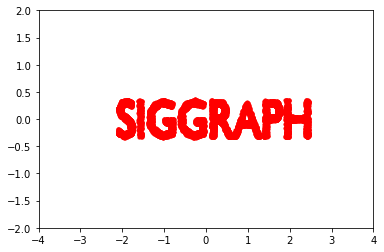

In [8]:
if TARGET_DENSITY == 'SIGGRAPH':
    import pickle
    with open('siggraph.pkl', 'rb') as f:
        X = np.array(pickle.load(f))
    X -= np.mean(X, axis=0)  # center
    xlim, ylim = [-4, 4], [-2, 2]
elif TARGET_DENSITY == 'MOONS':
    from sklearn import cluster, datasets, mixture
    from sklearn.preprocessing import StandardScaler
    n_samples = 1000
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
    X, y = noisy_moons
    X = StandardScaler().fit_transform(X)
    xlim, ylim = [-2, 2], [-2, 2]
elif TARGET_DENSITY == 'GAUSSIAN':
    mean = [0.4, 1]
    A = np.array([[2, .3], [-1., 4]])
    cov = A.T.dot(A)
    print(mean)
    print(cov)
    X = np.random.multivariate_normal(mean, cov, 2000)
    xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(X.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=X.shape[0])
dataset = dataset.prefetch(3 * settings[TARGET_DENSITY]['batch_size'])
dataset = dataset.batch(settings[TARGET_DENSITY]['batch_size'])
data_iterator = dataset.make_one_shot_iterator()
x_samples = data_iterator.get_next()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


## Real-NVP

In [33]:
def net(x, out_size):
    return layers.stack(x, layers.fully_connected, [512, 512, out_size])

# Affine Coupling layer for Real-NVP


class NVPCoupling(tfb.Bijector):
    """NVP affine coupling layer for 2D units.
    """

    def __init__(self, D, d, layer_id=0, validate_args=False, name="NVPCoupling"):
        """
        Args:
          d: First d units are pass-thru units.
        """
        # first d numbers decide scaling/shift factor for remaining D-d numbers.
        super(NVPCoupling, self).__init__(
            forward_min_event_ndims=1, validate_args=validate_args, name=name)
        self.D, self.d = D, d
        self.id = layer_id
        # create variables here
        tmp = tf.placeholder(dtype=DTYPE, shape=[1, self.d])
        self.s(tmp)
        self.t(tmp)

    def s(self, xd):
        with tf.variable_scope('s%d' % self.id, reuse=tf.AUTO_REUSE):
            return net(xd, self.D - self.d)

    def t(self, xd):
        with tf.variable_scope('t%d' % self.id, reuse=tf.AUTO_REUSE):
            return net(xd, self.D - self.d)

    def _forward(self, x):
        xd, xD = x[:, :self.d], x[:, self.d:]
        yD = xD * tf.exp(self.s(xd)) + self.t(xd)  # [batch, D-d]
        return tf.concat([xd, yD], axis=1)

    def _inverse(self, y):
        yd, yD = y[:, :self.d], y[:, self.d:]
        xD = (yD - self.t(yd)) * tf.exp(-self.s(yd))
        return tf.concat([yd, xD], axis=1)

    def _forward_log_det_jacobian(self, x):
        xd = x[:, :self.d]
        return tf.reduce_sum(self.s(xd), axis=1)

## BatchNorm Bijector

In [34]:
class BatchNorm(tfb.Bijector):
    def __init__(self, eps=1e-5, decay=0.95, validate_args=False, name="batch_norm"):
        super(BatchNorm, self).__init__(
            event_ndims=1, validate_args=validate_args, name=name)
        self._vars_created = False
        self.eps = eps
        self.decay = decay

    def _create_vars(self, x):
        n = x.get_shape().as_list()[1]
        with tf.variable_scope(self.name):
            self.beta = tf.get_variable('beta', [1, n], dtype=DTYPE)
            self.gamma = tf.get_variable('gamma', [1, n], dtype=DTYPE)
            self.train_m = tf.get_variable(
                'mean', [1, n], dtype=DTYPE, trainable=False)
            self.train_v = tf.get_variable(
                'var', [1, n], dtype=DTYPE, initializer=tf.ones_initializer, trainable=False)
        self._vars_created = True

    def _forward(self, u):
        if not self._vars_created:
            self._create_vars(u)
        return (u - self.beta) * tf.exp(-self.gamma) * tf.sqrt(self.train_v + self.eps) + self.train_m

    def _inverse(self, x):
        # Eq 22. Called during training of a normalizing flow.
        if not self._vars_created:
            self._create_vars(x)
        # statistics of current minibatch
        m, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        # update train statistics via exponential moving average
        update_train_m = tf.assign_sub(
            self.train_m, self.decay * (self.train_m - m))
        update_train_v = tf.assign_sub(
            self.train_v, self.decay * (self.train_v - v))
        # normalize using current minibatch statistics, followed by BN scale and shift
        with tf.control_dependencies([update_train_m, update_train_v]):
            return (x - m) * 1. / tf.sqrt(v + self.eps) * tf.exp(self.gamma) + self.beta

    def _inverse_log_det_jacobian(self, x):
        # at training time, the log_det_jacobian is computed from statistics of the
        # current minibatch.
        if not self._vars_created:
            self._create_vars(x)
        _, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        abs_log_det_J_inv = tf.reduce_sum(
            self.gamma - .5 * tf.log(v + self.eps))
        return abs_log_det_J_inv

## Construct Flow

In [35]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))

In [36]:
num_bijectors = settings[TARGET_DENSITY]['num_bijectors']
bijectors = []

for i in range(num_bijectors):
    if MODEL == 'NVP':
        bijectors.append(NVPCoupling(D=2, d=1, layer_id=i))
    elif MODEL == 'MAF':
        bijectors.append(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512])))
    elif MODEL == 'IAF':
        bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512]))))
    if USE_BATCHNORM and i % 2 == 0:
        # BatchNorm helps to stabilize deep normalizing flows, esp. Real-NVP
        bijectors.append(BatchNorm(name='batch_norm%d' % i))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
# Discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [37]:
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector)

## Visualization (before training)

In [38]:
# visualization
x = base_dist.sample(8000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [39]:
sess.run(tf.global_variables_initializer())

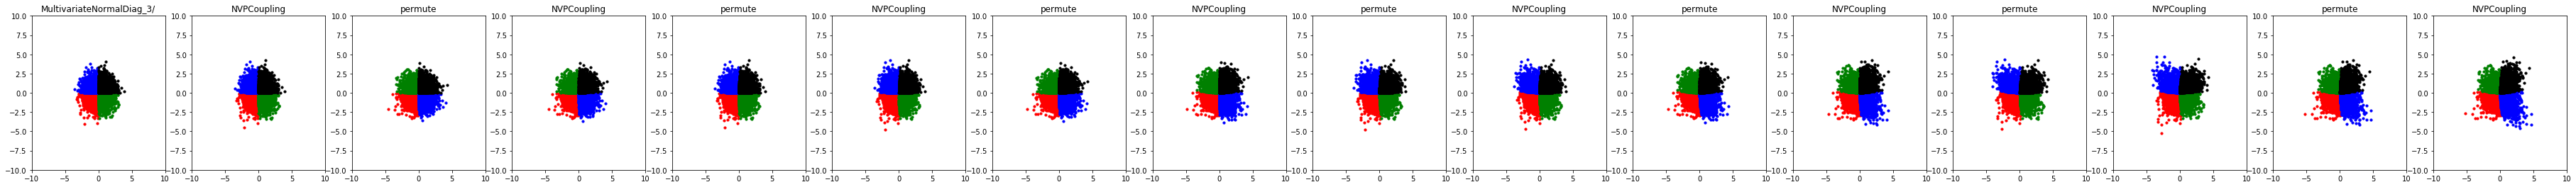

In [40]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-10, 10])
    arr[i].set_ylim([-10, 10])
    arr[i].set_title(names[i])

## Optimize Flow

In [41]:
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [42]:
sess.run(tf.global_variables_initializer())

In [ ]:
NUM_STEPS = int(settings[TARGET_DENSITY]['train_iters'])
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 1000 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e4) == 0:
        print(i, np_loss)
start = 0
plt.plot(np_losses[start:])

0 3.0165813
10000 2.3512661
20000 2.4254425
30000 2.4664779
40000 2.3529866
50000 2.51088
60000 2.3612733
70000 2.3823068
80000 2.5315883
90000 2.328015
100000 2.4721098


In [ ]:
results = sess.run(samples)
X0 = results[0]
rows = 2
cols = int(len(results) / 2)
f, arr = plt.subplots(2, cols, figsize=(4 * (cols), 4 * rows))
i = 0
for r in range(rows):
    for c in range(cols):
        X1 = results[i]
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
        arr[r, c].set_xlim([-5, 5])
        arr[r, c].set_ylim([-5, 5])
        arr[r, c].set_title(names[i])

        i += 1
plt.savefig('siggraph_trained.png', dpi=300)

In [ ]:
# plot the last one, scaled up
idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
plt.xlim([-3, 3])
plt.ylim([-.5, .5])
plt.savefig('siggraph_out.png', dpi=300)